<a href="https://colab.research.google.com/github/PedroCanoM/Idal_ia3/blob/main/Sea_Ice_Extent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 1. Read and clean the data.
Load the monthly sea ice extent (SIE) monthly data provided in the file 'SeaIce.txt'. Note variables ``extent`` (SIE) and ``area`` should be greater or equal than zero. Detect possible outliers and clean the data.  


### Climate Change and Sea Ice Extent

We want to answer the question: Has there been a decrease in the amount of ice in the last years?

For that we will use the sea ice extent measurements (in millions of square km) from the [National Snow & Ice Data Center](https://nsidc.org).

We perform the following processing steps:
1. Read and clean the data.
2. Normalize the Sea Ice Extent (SIE) data and visualize its temporal trend.
3. Compute the SIE temporal trend as a simple linear regression (OLS) and quantitatively evaluate it.
4. Estimate the sea ice extent for 2025.


In [17]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns

In [3]:
#cargamos los datos
df = pd.read_csv('SeaIce.txt', sep='\s+')
df.head()

,year,mo,data_type,region,extent,area
0,1979,1,Goddard,N,15.54,12.33
1,1980,1,Goddard,N,14.96,11.85
2,1981,1,Goddard,N,15.03,11.82
3,1982,1,Goddard,N,15.26,12.11
4,1983,1,Goddard,N,15.10,11.92


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 424 entries, 0 to 423
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   year       424 non-null    int64  
 1   mo         424 non-null    int64  
 2   data_type  424 non-null    object 
 3   region     424 non-null    object 
 4   extent     424 non-null    float64
 5   area       424 non-null    float64
dtypes: float64(2), int64(2), object(2)
memory usage: 20.0+ KB


In [5]:
#La unidad de las observaciones en extent y area es el millon de kilómetros cuadrados.
#Que sean floats podrían indicarnos que no incluyen valores extraños. Después buscaremos outlaiers.
#Comprobamos que no hayan valores extraños en las otras columnas.
for col in ['year', 'mo', 'data_type', 'region']:
    print(f'Columna {col}:')
    print(df[col].value_counts(), '\n')

Columna year:
1996    12
1988    12
1994    12
1993    12
1992    12
1991    12
1990    12
1989    12
1987    12
2013    12
1986    12
1985    12
1984    12
1983    12
1982    12
1981    12
1995    12
1997    12
1979    12
2006    12
2012    12
2011    12
2010    12
2009    12
2008    12
2007    12
2005    12
1998    12
2004    12
2003    12
2002    12
2001    12
2000    12
1999    12
1980    12
2014     2
1978     2
Name: year, dtype: int64 

Columna mo:
12    36
11    36
2     36
1     36
10    35
9     35
8     35
7     35
6     35
5     35
4     35
3     35
Name: mo, dtype: int64 

Columna data_type:
Goddard    409
NRTSI-G     13
-9999        2
Name: data_type, dtype: int64 

Columna region:
N    424
Name: region, dtype: int64 



In [6]:
#Observamos que las entradas en las columnas de año y mes tienen sentido. 
#La columna region no es informativa.
#En la columna data_type nos indican cuales han sido los datos diarios en los que se ha basado el cálculo de los
# valores mensuales (https://nsidc.org/sites/nsidc.org/files/G02135-V3.0_0.pdf#18). Existen tres observaciones, dos 
# (Goddarm, NRTSI-G) válidas y otra (-9999) que es un error. Quitamos estas últimas.
df=df[df['data_type'] != '-9999']
df['data_type'].value_counts()

Goddard    409
NRTSI-G     13
Name: data_type, dtype: int64

In [7]:
#Buscamos outlaiers en la extent y area. Consideraremos outlaiers aquellos valores que se alejen 1.5 veces el rango intercuartílico por debajo de Q1 y por arriba de Q3
def get_outlaiers(x):
    q1, q3 = x.quantile((0.25, 0.75))
    iqr = q3 - q1

    return(x[(x < q1 -  1.5*iqr) | (x > q3 +  1.5*iqr)])

print(len(get_outlaiers(df['extent'])), len(get_outlaiers(df['area'])))
#No encontramos outlaiers.

0 0


In [8]:
#Quitamos la columna region.
del df['region']
df.head()

,year,mo,data_type,extent,area
0,1979,1,Goddard,15.54,12.33
1,1980,1,Goddard,14.96,11.85
2,1981,1,Goddard,15.03,11.82
3,1982,1,Goddard,15.26,12.11
4,1983,1,Goddard,15.10,11.92


In [9]:
#Añadimos una columna con las fechas
dates = df.iloc[:,0:2].copy()
dates.columns = ['year', 'month']
dates['day']=[1]*len(dates)

df['date']=pd.to_datetime(dates, format="")
df.head(25)

,year,mo,data_type,extent,area,date
0,1979,1,Goddard,15.54,12.33,1979-01-01
1,1980,1,Goddard,14.96,11.85,1980-01-01
2,1981,1,Goddard,15.03,11.82,1981-01-01
3,1982,1,Goddard,15.26,12.11,1982-01-01
4,1983,1,Goddard,15.10,11.92,1983-01-01
5,1984,1,Goddard,14.61,11.60,1984-01-01
6,1985,1,Goddard,14.86,11.60,1985-01-01
7,1986,1,Goddard,15.02,11.79,1986-01-01
8,1987,1,Goddard,15.20,11.81,1987-01-01
10,1989,1,Goddard,15.12,13.11,1989-01-01


### 2. Normalize the SIE data and visualize its temporal trend.

Visualize there is a monthly dependence of SIE, explore the linear relationship using ``lmplot``.
Compute the mean and variance of SIE for each month.

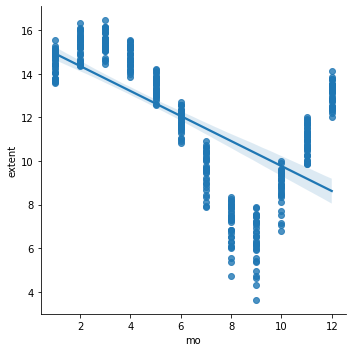

In [20]:
sns.lmplot(data=df, x='mo', y='extent')

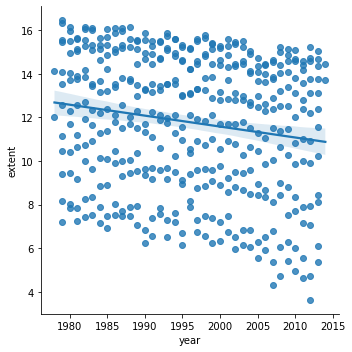

In [28]:
sns.lmplot(data=df, x='year', y='extent')

In [26]:
px.scatter(df, x='mo', y='extent')

In [27]:
px.scatter(df, x='year', y='extent')

In [10]:
#Comenzamos presentando algunas gráficas para visualizar la evolución de extend por meses (dentro de cada año),
#y por años (durante todo el periodo de estudio).

years = df.sort_values('year').year.unique()
months = np.arange(12) + 1
z = []

for year in years:
    aux = []
    for month in months:
        try:
            aux.append(df[(df['year'] == year) & (df['mo'] == month)]['extent'].iloc[0])
        except:
            aux.append(None)
    z.append(aux)

fig = go.Figure(data=go.Heatmap(
    z=z,
    x=months,
    y = years,
    colorscale = 'Ice'
    ))
fig.layout.height = 950
fig.show()

#En el mapa de calor vemos como los valores más pequeños de SIE se dan en los últimos meses del verano (agosto y septiembre),
#mientras que los mayores se encuentran en los últimos meses del invierno (febrero, marzo).
#Los cambios entre valores máximos y mínimos no parecen ocurrir bruscamente.
#Respecto al desarrollo por años, podemos ver como, en los últimos años del estudio, la cantidad de hielo ha
#disminuido respecto a los primeros. Esta variación es más evidente en los meses de verano.
#

Normalize the SIE data: subtract the monthly mean and then convert to percent difference by dividing by the monthly mean and then multiplying by 100. Use the normalized SIE for the rest of the exercise.

In [11]:
#Ahora mostraremos la distribución durante un año y la mensual a lo largo de todos los años en gráficas dinámica.
#Para ellos eliminamos los años con pocos datos y completamos los que casi tengan 12.

#identificamos los años con algún mes faltante
aux = df['year'].value_counts()
ms = aux[aux.values<12]
ys = df[df['year'].isin(ms.index)]['year'].unique()

#identificamos los meses faltantes
months = set(np.arange(12) + 1)
empty_y_m=dict()
for y in ys:
    empty_months = months - set(df['mo'][df['year'] == y])
    empty_y_m[y] = empty_months

print(empty_y_m)
    

{1987: {12}, 2014: {3, 4, 5, 6, 7, 8, 9, 10, 11, 12}, 1988: {1}, 1978: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10}}


In [12]:
#Consideramos que a 2014 y a 1978, les faltan demasiados meses y eliminamos esas observaciones.
df1 = df[~df['year'].isin((2014, 1978))].copy()
df1 = df1.reset_index(drop=True)
print(len(df1))
df1.tail()

418


,year,mo,data_type,extent,area,date
413,2009,12,Goddard,12.51,10.25,2009-12-01
414,2010,12,Goddard,12.02,10.08,2010-12-01
415,2011,12,Goddard,12.40,10.28,2011-12-01
416,2012,12,Goddard,12.20,10.11,2012-12-01
417,2013,12,NRTSI-G,12.38,10.48,2013-12-01


In [13]:
#A 1987 y a 1988 les faltan diciembre y enero respectivamente. Añadiremos esas observaciones asignando a extent y a area la media de los valores
#de esos mismos meses los 6 años de alrededor.

del empty_y_m[2014]
del empty_y_m[1978]

for y, ms in empty_y_m.items():
  for m in ms: #en caso de que hubiera más de un mes

    e = df1['extent'][(df1['year'].isin(range(y-3, y+4))) & (df1['mo'] == m)].mean()
    a = df1['area'][(df1['year'].isin(range(y-3, y+4))) & (df1['mo'] == m)].mean()

    df1.loc[len(df1)] = [y, m, 'Created', e, a, pd.Timestamp(year = y, month = m, day =1 )]

print(len(df1))
df1.tail()


420


,year,mo,data_type,extent,area,date
415,2011,12,Goddard,12.400000,10.280000,2011-12-01
416,2012,12,Goddard,12.200000,10.110000,2012-12-01
417,2013,12,NRTSI-G,12.380000,10.480000,2013-12-01
418,1987,12,Created,13.381667,10.945000,1987-12-01
419,1988,1,Created,14.935000,12.253333,1988-01-01


In [14]:
px.line(df1.sort_values('date'), x = 'mo', y = 'extent',
  animation_frame = "year", 
  range_y=[df1['extent'].min()-0.25, df1['extent'].max()+0.25],
  labels = {'mo' : 'Month', 'extent' : 'Extent', 'year' : 'Year'} )

#Vemos la evolución dentro de cada año. Comprovamos que es 
#aparentemente suave y periódica de invierno a invierno.
#Si avanzamos en el tiempo, apreciamos como la SIE de cada mes 
#se ha ido reduciendo con el paso del tiempo, pese a presentar fluctuaciones año
# a año.

In [16]:
px.scatter(df1.sort_values('date'), x = 'year', y = 'extent',
  animation_frame = "mo", 
  range_y=[df1['extent'].min()-0.25,df1['extent'].max()+0.25],
  labels = {'mo': 'Month', 'extent':'Extent', 'year':'Year'})

#Vemos la evolución de cada mes a lo largo de todo el periodo de estudio.
#Confirmando lo que veíamos antes, el SIE de cada mes ha disminuyendo a lo largo del
#del tiempo, siguiendo una evolución oscilatoria.
#La animación nos muestra la tendencia estacional.

In [ ]:
px.scatter(df1.sort_values('date'), x = 'year', y = 'extent',
  animation_frame = "mo", opacity = 0.65,
  trendline='ols', trendline_color_override='darkblue',
  range_y=[df1['extent'].min()-0.25,df1['extent'].max()+0.25],
  labels = {'mo': 'Month', 'extent':'Extent', 'year':'Year'})

In [ ]:
#your response here

Visualize the trend of SIE per year considering:1) all months, 2) January, 3) August

In [ ]:
#your response here

Calculate the Pearson correlation coefficient and the p-value for testing non-correlation of the SIE temporal trend (consider all months). Is it significant?

In [ ]:
#your response here

### 3. Compute the trend as a simple linear regression (OLS) and quantitatively evaluate it.

Provide the estimated parameters for the linear regression. 
Evaluate the quality of fit quantitatively and graphically.

In [ ]:
#your solution here

### 4. Estimate the sea ice extent for January 2025

 Is there a negative trend in the evolution of sea ice extent over recent years? 

In [ ]:
#your solution here